In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [ ]:
# View all of the classes that automap found
classes = Base.classes.keys()
classes.text


['measurement', 'station']

In [14]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)
session.text

# Exploratory Precipitation Analysis

In [16]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

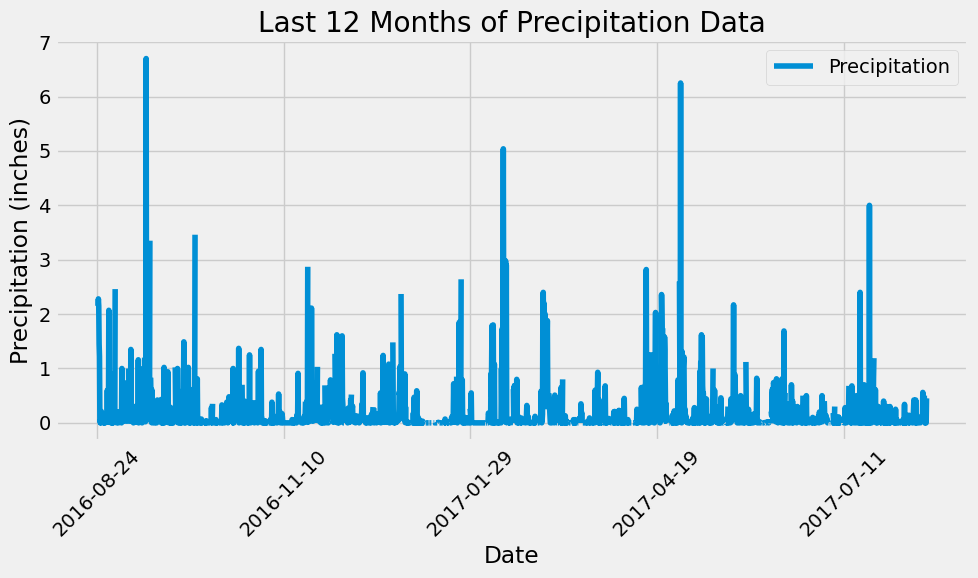

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = session.query(func.max(Measurement.date)).scalar()
one_year_ago = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='Date', y='Precipitation', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Last 12 Months of Precipitation Data')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['Precipitation'].describe()
summary_stats

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [21]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()

for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = active_stations[0][0]  # Get the station id of the most active station

temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                    filter(Measurement.station == most_active_station_id).all()

# Print the lowest, highest, and average temperature
lowest_temp = temperature_stats[0][0]
highest_temp = temperature_stats[0][1]
avg_temp = temperature_stats[0][2]

print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp}")
print(f"")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


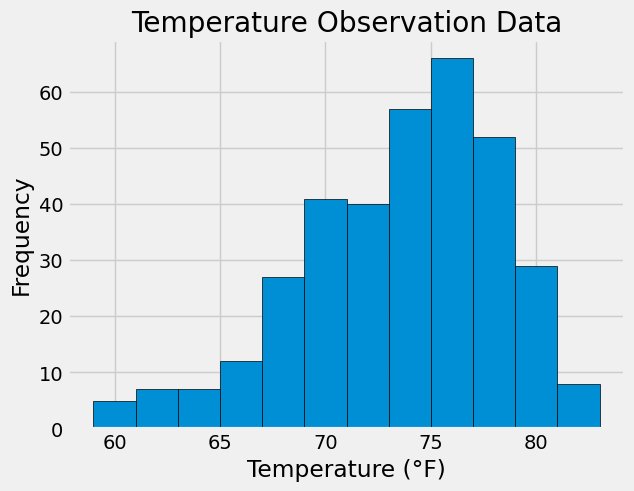

In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs).\
                    filter(Measurement.station == most_active_station_id).\
                    filter(Measurement.date >= one_year_ago).all()

# Convert the query results to a list
temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.hist(temperatures, bins=12, edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data')
plt.show()

# Close Session

In [24]:
# Close Session
session.close()

In [ ]:
from flask import Flask, jsonify

# Create an instance of the Flask app
app = Flask(__name__)

# Define the homepage route
@app.route("/")
def home():
    """Homepage route"""
    return (
        f"Welcome to the Flask API<br/>"
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/<start><br/>"
        f"/api/v1.0/<start>/<end>"
    )

# Define the /api/v1.0/precipitation route
@app.route("/api/v1.0/precipitation")
def precipitation():
    """Precipitation route"""
    # Perform the query to retrieve precipitation data for the last 12 months
    results = session.query(Measurement.date, Measurement.prcp).\
              filter(Measurement.date >= one_year_ago).all()

    # Create a dictionary with date as the key and precipitation as the value
    precipitation_data = {date: prcp for date, prcp in results}

    # Return the precipitation data as JSON
    return jsonify(precipitation_data)

# Define the /api/v1.0/stations route
@app.route("/api/v1.0/stations")
def stations():
    """Stations route"""
    # Perform the query to retrieve the list of stations
    results = session.query(Station.station, Station.name).all()

    # Create a list of dictionaries with station ID and name
    station_list = [{"Station": station, "Name": name} for station, name in results]

    # Return the list of stations as JSON
    return jsonify(station_list)

# Define the /api/v1.0/tobs route
@app.route("/api/v1.0/tobs")
def tobs():
    """Temperature Observations route"""
    # Perform the query to retrieve temperature data for the last 12 months for the most active station
    results = session.query(Measurement.date, Measurement.tobs).\
              filter(Measurement.station == most_active_station_id).\
              filter(Measurement.date >= one_year_ago).all()

    # Create a list of dictionaries with date and temperature
    temperature_list = [{"Date": date, "Temperature": tobs} for date, tobs in results]

    # Return the temperature data as JSON
    return jsonify(temperature_list)

# Define the /api/v1.0/<start> route
@app.route("/api/v1.0/<start>")
def temp_range_start(start):
    """Temperature range from a start date route"""
    # Perform the query to retrieve temperature data for a given start date
    results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
              filter(Measurement.station == most_active_station_id).\
              filter(Measurement.date >= start).all()

    # Create a dictionary with the temperature statistics
    temperature_stats = {
        "Minimum Temperature": results[0][0],
        "Average Temperature": results[0][1],
        "Maximum Temperature": results[0][2]
    }

    # Return the temperature statistics as JSON
    return jsonify(temperature_stats)

# Define the /api/v1.0/<start>/<end> route
@app.route("/api/v1.0/<start>/<end>")
def temp_range_start_end(start, end):
    """Temperature range between a start and end date route

In [ ]:
# Define the /api/v1.0/precipitation route
@app.route("/api/v1.0/precipitation")
def precipitation():
    """Precipitation route"""
    # Perform the query to retrieve precipitation data for the last 12 months
    results = session.query(Measurement.date, Measurement.prcp).\
              filter(Measurement.date >= one_year_ago).all()

    # Create a dictionary with date as the key and precipitation as the value
    precipitation_data = {date: prcp for date, prcp in results}

    # Return the precipitation data as JSON
    return jsonify(precipitation_data)

In [ ]:
# Define the /api/v1.0/stations route
@app.route("/api/v1.0/stations")
def stations():
    """Stations route"""
    # Perform the query to retrieve the list of stations
    results = session.query(Station.station, Station.name).all()

    # Create a list of dictionaries with station ID and name
    station_list = [{"Station": station, "Name": name} for station, name in results]

    # Return the list of stations as JSON
    return jsonify(station_list)

In [ ]:
# Define the /api/v1.0/tobs route
@app.route("/api/v1.0/tobs")
def tobs():
    """Temperature Observations route"""
    # Perform the query to retrieve temperature data for the last 12 months for the most active station
    results = session.query(Measurement.date, Measurement.tobs).\
              filter(Measurement.station == most_active_station_id).\
              filter(Measurement.date >= one_year_ago).all()

    # Create a list of dictionaries with date and temperature
    temperature_list = [{"Date": date, "Temperature": tobs} for date, tobs in results]

    # Return the temperature data as JSON
    return jsonify(temperature_list)

In [ ]:
# Define the /api/v1.0/<start> route
@app.route("/api/v1.0/<start>")
def temp_range_start(start):
    """Temperature range from a start date route"""
    # Perform the query to retrieve temperature data for a given start date
    results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
              filter(Measurement.station == most_active_station_id).\
              filter(Measurement.date >= start).all()

    # Create a dictionary with the temperature statistics
    temperature_stats = {
        "Minimum Temperature": results[0][0],
        "Average Temperature": results[0][1],
        "Maximum Temperature": results[0][2]
    }

    # Return the temperature statistics as JSON
    return jsonify(temperature_stats)

# Define the /api/v1.0/<start>/<end> route
@app.route("/api/v1.0/<start>/<end>")
def temp_range_start_end(start, end):
    """Temperature range between a start and end date route"""
    # Perform the query to retrieve temperature data for a given start and end date
    results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
              filter(Measurement.station == most_active_station_id).\
              filter(Measurement.date >= start).\
              filter(Measurement.date <= end).all()

    # Create a dictionary with the temperature statistics
    temperature_stats = {
        "Minimum Temperature": results[0][0],
        "Average Temperature": results[0][1],
        "Maximum Temperature": results[0][2]
    }

    # Return the temperature statistics as JSON
    return jsonify(temperature_stats)